In [46]:
# initialize environment
from urbantrips.datamodel.misc import create_line_and_branches_metadata
from urbantrips.utils import utils

# Check config file consistency
utils.check_config()

# Create basic dir structure:
utils.create_directories()

# Create DB:
utils.create_db()
# create_line_and_branches_metadata()

Chequeando archivo de configuracion
Proceso de chequeo de archivo de configuración concluido con éxito
create_db Bases abiertas con exito
Tablas originales creadas
Fin crear base
 Finalizado. Tardo 0.89 segundos


In [47]:
# # process_transactions
# from urbantrips.datamodel import legs, trips
# from urbantrips.datamodel import transactions as trx
# from urbantrips.destinations import destinations as dest
# from urbantrips.geo import geo
# from urbantrips.carto import carto
# from urbantrips.utils import utils



# # Check config file consistency
# utils.check_config()

# # Read config file
# configs = utils.leer_configs_generales()
# geolocalizar_trx_config = configs["geolocalizar_trx"]

# # trx configs
# nombres_variables_trx = configs["nombres_variables_trx"]
# formato_fecha = configs["formato_fecha"]
# col_hora = configs["columna_hora"]
# tipo_trx_invalidas = configs["tipo_trx_invalidas"]
# nombre_archivo_trx = configs["nombre_archivo_trx"]

# tolerancia_parada_destino = configs["tolerancia_parada_destino"]
# resolucion_h3 = configs["resolucion_h3"]
# trx_order_params = {
#     "criterio": configs["ordenamiento_transacciones"],
#     "ventana_viajes": configs["ventana_viajes"],
#     "ventana_duplicado": configs["ventana_duplicado"],
# }

# # gps configs
# if geolocalizar_trx_config:
#     nombre_archivo_gps = configs["nombre_archivo_gps"]
#     nombres_variables_gps = configs["nombres_variables_gps"]
# else:
#     nombre_archivo_gps = None
#     nombres_variables_gps = None

# # Compute tolerance in h3 ring
# ring_size = geo.get_h3_buffer_ring_size(
#     resolucion_h3, tolerancia_parada_destino
# )

# # Produce transaction table
# trx.create_transactions(geolocalizar_trx_config,
#                         nombre_archivo_trx,
#                         nombres_variables_trx,
#                         formato_fecha,
#                         col_hora,
#                         tipo_trx_invalidas,
#                         nombre_archivo_gps,
#                         nombres_variables_gps)

# # Turn transactions into legs
# legs.create_legs_from_transactions(trx_order_params)

# # Update destination validation matrix
# carto.update_stations_catchment_area(ring_size=ring_size)

# # Infer legs destinations
# dest.infer_destinations()

# # Fix trips with same OD
# trips.rearrange_trip_id_same_od()

# # Produce trips and users tables from legs
# trips.create_trips_from_legs()

# # Upload route geometries
# carto.upload_routes_geoms()

# # Inferir route geometries based on legs data
# carto.infer_routes_geoms(plotear_lineas=False)

In [25]:
# run_postprocessing

from urbantrips.datamodel.misc import persist_datamodel_tables
from urbantrips.kpi import kpi
from urbantrips.viz import viz
from urbantrips.viz_ppt_utils import viz_ppt_utils
from urbantrips.carto import carto
from urbantrips.utils import utils
import os
os.environ['USE_PYGEOS'] = '0'
utils.check_config()

# # # Compute and viz route section load by line
# # kpi.compute_route_section_load(id_linea=False, rango_hrs=False) #, day_type='weekend'
# viz.visualize_route_section_load(id_linea=False, rango_hrs=False) #, day_type='weekend'

# # Create TAZs
# carto.create_zones_table()

# # Create voronoi TAZs
# carto.create_voronoi_zones()

# # Create distances table
# carto.create_distances_table(use_parallel=True)

# # Persist datamodel into csv tables
# persist_datamodel_tables()

# Poduce main viz
viz.create_visualizations()

viz_ppt_utils.create_ppt()

# # Compute KPI
# kpi.compute_kpi()



Chequeando archivo de configuracion
Proceso de chequeo de archivo de configuración concluido con éxito
Creando zonificación para dashboard


InterfaceError: Error binding parameter 1 - probably unsupported type.

In [29]:
# def save_zones():
#     """
#     Esta función guarda las geografías de las zonas para el dashboard
#     """
if True:
    print('Creando zonificación para dashboard')
    configs = leer_configs_generales()

    geo_files = [['Zona_voi.geojson', 'Zona_voi']]

    if configs["zonificaciones"]:
        for n in range(0, 5):

            try:
                file_zona = configs["zonificaciones"][f"geo{n+1}"]
                var_zona = configs["zonificaciones"][f"var{n+1}"]
                geo_files += [[file_zona, var_zona]]

                try:
                    matriz_order = configs["zonificaciones"][f"orden{n+1}"]
                except KeyError:
                    matriz_order = ""


            except KeyError:
                pass

    zonas = pd.DataFrame([])        
    for i in geo_files:
        file = os.path.join("data", "data_ciudad", f'{i[0]}')
        if os.path.isfile(file):
            df = gpd.read_file(file)
            df = df[[i[1], 'geometry']]
            df.columns = ['Zona', 'geometry']
            df['tipo_zona'] = i[1]            
            zonas = pd.concat([zonas, df])

    zonas = zonas.dissolve(by=['tipo_zona','Zona'], as_index=False)
    zonas['wkt'] = zonas.geometry.to_wkt()
    zonas = zonas.drop(['geometry'], axis=1)
    
    conn_dash = iniciar_conexion_db(tipo='dash')
    zonas.to_sql("zonas", conn_dash, if_exists="replace", index=False)
    conn_dash.close()

Creando zonificación para dashboard
alias amba2_muestra10_
data\db\amba2_muestra10_dash.sqlite


In [3]:
from urbantrips.utils.utils import (
    leer_configs_generales,
    traigo_db_path,
    iniciar_conexion_db,
    leer_alias)
import pandas as pd
import sqlite3
import os
import yaml


pd.options.mode.chained_assignment = None



def leer_alias(tipo='data'):
    """
    Esta funcion toma un tipo de datos (data o insumos)
    y devuelve el alias seteado en el archivo de congifuracion
    """
    configs = leer_configs_generales()
    # Setear el tipo de key en base al tipo de datos
    if tipo == 'data':
        key = 'alias_db_data'
    elif tipo == 'insumos':
        key = 'alias_db_insumos'
    elif tipo == 'dash':
        key = 'alias_db_data'
    else:
        raise ValueError('tipo invalido: %s' % tipo)
    # Leer el alias
    try:
        alias = configs[key] + '_'
    except KeyError:
        alias = ''
    print('alias', alias)
    return alias


def traigo_db_path(tipo='data'):
    """
    Esta funcion toma un tipo de datos (data o insumos)
    y devuelve el path a una base de datos con esa informacion
    """
    if tipo not in ('data', 'insumos', 'dash'):
        raise ValueError('tipo invalido: %s' % tipo)

    alias = leer_alias(tipo)
    db_path = os.path.join("data", "db", f"{alias}{tipo}.sqlite")

    return db_path


def iniciar_conexion_db(tipo='data'):
    """"
    Esta funcion toma un tipo de datos (data o insumos)
    y devuelve una conexion sqlite a la db
    """
    db_path = traigo_db_path(tipo)
    print(db_path)
    conn = sqlite3.connect(db_path, timeout=10)
    return conn


# Leer informacion de viajes y distancias
conn_data = iniciar_conexion_db(tipo='data')
conn_insumos = iniciar_conexion_db(tipo='insumos')

viajes = pd.read_sql_query(
    """
    SELECT *
    FROM viajes
    """,
    conn_data,
)

factores_expansion = pd.read_sql_query(
    """
    SELECT *
    FROM factores_expansion
    """,
    conn_data,
)

distancias = pd.read_sql_query(
    """
    SELECT *
    FROM distancias
    """,
    conn_insumos,
)

conn_insumos.close()
conn_data.close()

alias amba2_muestra10_
data\db\amba2_muestra10_data.sqlite
alias amba_
data\db\amba_insumos.sqlite


In [ ]:
import geopandas as gpd
import pandas as pd
import os
alias ='amba2_muestra10_'
desc_dia = '11/2022'
tipo_dia = 'Fin de semana'
var_zona = 'h3_r6'
filtro1 = 'Todos'
# df_agg = gpd.read_file('D:\\sanapolsky\\Google Drive\\Python 2.0\\github\\UrbanTrips\\UrbanTrips\\resultados\\tmp\\amba2_muestra10_2022-11(Fin de semana)_h3_r7_lineas_deseo.geojson')
# df_agg.head()

In [ ]:
df_agg[((df_agg.alias==alias[:-1])&
       (df_agg.desc_dia==desc_dia)&
       (df_agg.tipo_dia==tipo_dia)&
       (df_agg.var_zona==var_zona.replace('h3_r', 'H3 Resolucion '))&
        (df_agg.filtro1==filtro1)
      )]

In [53]:
# if not 'h3_r' in var_zona:
#     df_folium = df_agg.copy()
#     df_folium.columns = ['origen', 'destino', 'factor_expansion', 'lon_o', 'lat_o', 'lon_d', 'lat_d', 'cumsum', 'geometry']

#     df_folium['alias'] = alias[:-1]
#     df_folium['desc_dia'] = desc_dia
#     df_folium['tipo_dia'] = tipo_dia
#     df_folium['var_zona'] = var_zona.replace('h3_r', 'H3 Resolucion ')
#     df_folium['filtro1'] = filtro1

#     db_path = os.path.join(
#                         "resultados", "tmp", f"dash_lineas_deseo.geojson")

#     if os.path.isfile(db_path):
#         df_folium_ant = gpd.read_file(db_path)
#         df_folium_ant = df_folium_ant[~((df_folium_ant.alias==alias[:-1])&
#                                        (df_folium_ant.desc_dia==desc_dia)&
#                                        (df_folium_ant.tipo_dia==tipo_dia)&
#                                        (df_folium_ant.var_zona==var_zona.replace('h3_r', 'H3 Resolucion '))&
#                                         (df_folium_ant.filtro1==filtro1)
#                                       )]

#         df_folium=pd.concat([df_folium_ant, df_folium], ignore_index=True)

#     df_folium.to_file(db_path)
# print(len(df_folium))

43554


In [5]:
db_path = os.path.join(
                    "resultados", "tmp", f"dash_lineas_deseo.geojson")

if os.path.isfile(db_path):
    df_folium = gpd.read_file(db_path)
print(len(df_folium))
df_folium

                    


126345


,origen,destino,factor_expansion,lon_o,lat_o,lon_d,lat_d,cumsum,alias,desc_dia,tipo_dia,var_zona,filtro1,geometry
0,1,2,900903,-58.435626,-34.622250,-58.696472,-34.563024,69.0,amba2_muestra10,11/2022,Fin de semana,Zona_voi,Todos los viajes,"LINESTRING (-58.43563 -34.62225, -58.69647 -34..."
1,1,3,735048,-58.435626,-34.622250,-58.474399,-34.803115,84.0,amba2_muestra10,11/2022,Fin de semana,Zona_voi,Todos los viajes,"LINESTRING (-58.43563 -34.62225, -58.47440 -34..."
2,5,1,314814,-58.259580,-34.783770,-58.435626,-34.622250,95.0,amba2_muestra10,11/2022,Fin de semana,Zona_voi,Todos los viajes,"LINESTRING (-58.25958 -34.78377, -58.43563 -34..."
3,5,3,84551,-58.259580,-34.783770,-58.474399,-34.803115,95.0,amba2_muestra10,11/2022,Fin de semana,Zona_voi,Todos los viajes,"LINESTRING (-58.25958 -34.78377, -58.47440 -34..."
4,12,2,74275,-58.639857,-34.389845,-58.696472,-34.563024,96.0,amba2_muestra10,11/2022,Fin de semana,Zona_voi,Todos los viajes,"LINESTRING (-58.63986 -34.38985, -58.69647 -34..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126340,Comuna 13,Comuna 10,1033,-58.455972,-34.559455,-58.499582,-34.629064,90.0,amba2_muestra10,11/2022,Fin de semana,Partido,Punta Tarde,"LINESTRING (-58.45597 -34.55945, -58.49958 -34..."
126341,Comuna 4,Comuna 1,1033,-58.397118,-34.644410,-58.378447,-34.609929,90.0,amba2_muestra10,11/2022,Fin de semana,Partido,Punta Tarde,"LINESTRING (-58.39712 -34.64441, -58.37845 -34..."
126342,Comuna 6,Lomas de Zamora,1033,-58.441064,-34.619014,-58.418369,-34.748288,90.0,amba2_muestra10,11/2022,Fin de semana,Partido,Punta Tarde,"LINESTRING (-58.44106 -34.61901, -58.41837 -34..."
126343,Tigre,General San Martín,1032,-58.633927,-34.454906,-58.555168,-34.560945,90.0,amba2_muestra10,11/2022,Fin de semana,Partido,Punta Tarde,"LINESTRING (-58.63393 -34.45491, -58.55517 -34..."


In [49]:
df_folium

,origen,destino,factor_expansion,lon_o,lat_o,lon_d,lat_d,cumsum,alias,desc_dia,tipo_dia,var_zona,filtro1,geometry
0,87c2e3113ffffff,87c2e311effffff,45795,-58.378211,-34.607918,-58.396397,-34.599322,0.0,amba2_muestra10_,11/2022,Fin de semana,h3_r6,Todos,"LINESTRING (-58.37821 -34.60792, -58.39640 -34..."
1,87c2e3113ffffff,87c2e3118ffffff,40927,-58.378211,-34.607918,-58.415464,-34.585864,1.0,amba2_muestra10_,11/2022,Fin de semana,h3_r6,Todos,"LINESTRING (-58.37821 -34.60792, -58.41546 -34..."
2,87c2e3113ffffff,87c2e3024ffffff,38723,-58.378211,-34.607918,-58.456736,-34.560697,1.0,amba2_muestra10_,11/2022,Fin de semana,h3_r6,Todos,"LINESTRING (-58.37821 -34.60792, -58.45674 -34..."
3,87c2e3113ffffff,87c2e311cffffff,35265,-58.378211,-34.607918,-58.416067,-34.605060,2.0,amba2_muestra10_,11/2022,Fin de semana,h3_r6,Todos,"LINESTRING (-58.37821 -34.60792, -58.41607 -34..."
4,87c2e311effffff,87c2e3118ffffff,34729,-58.396397,-34.599322,-58.415464,-34.585864,2.0,amba2_muestra10_,11/2022,Fin de semana,h3_r6,Todos,"LINESTRING (-58.39640 -34.59932, -58.41546 -34..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87103,87c2e33a4ffffff,87c2e302effffff,15,-58.589529,-34.361765,-58.479153,-34.516441,100.0,amba2_muestra10,11/2022,Fin de semana,H3 Resolucion 6,Todos,"LINESTRING (-58.58953 -34.36176, -58.47915 -34..."
87104,87c2e33a4ffffff,87c2e3021ffffff,15,-58.589529,-34.361765,-58.475326,-34.537121,100.0,amba2_muestra10,11/2022,Fin de semana,H3 Resolucion 6,Todos,"LINESTRING (-58.58953 -34.36176, -58.47533 -34..."
87105,87c2e3110ffffff,87c2e02dbffffff,14,-58.380111,-34.627590,-58.722000,-34.929000,100.0,amba2_muestra10,11/2022,Fin de semana,H3 Resolucion 6,Todos,"LINESTRING (-58.38011 -34.62759, -58.72200 -34..."
87106,87c2e14eeffffff,87c2e1432ffffff,14,-59.033000,-34.793000,-58.946457,-34.927486,100.0,amba2_muestra10,11/2022,Fin de semana,H3 Resolucion 6,Todos,"LINESTRING (-59.03300 -34.79300, -58.94646 -34..."


In [3]:
from urbantrips.viz_ppt_utils import viz_ppt_utils

utils.check_config()
# Produce ppt

Chequeando archivo de configuracion
Proceso de chequeo de archivo de configuración concluido con éxito


In [7]:
import pandas as pd
import os
from urbantrips.utils.utils import (
    leer_configs_generales,
    traigo_db_path,
    iniciar_conexion_db,
    leer_alias)
import requests

In [8]:
import os
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN
from pptx.dml.color import RGBColor # ColorFormat, 
from PIL import Image, ImageDraw, ImageOps


def crop_imagen(filePath, reduce=1, altura_max=0, ancho_max=0, save=True, crop_left = 0, crop_top = 0, crop_right = 0, crop_bottom = 0):
    
    # Trim all png images with white background in a folder
    # Usage "python PNGWhiteTrim.py ../someFolder padding"

    image=Image.open(filePath)
    image.load()
    imageSize = image.size #tuple
    
    ## QUITA ESPACIOS EN BLANCO ALREDEDOR DE LA IMAGEN
    # remove alpha channel
    invert_im = image.convert("RGB")
    # invert image (so that white is 0)
    invert_im = ImageOps.invert(invert_im)
    imageBox = invert_im.getbbox()
    cropped=image.crop(imageBox)
    ## FIN DE QUITA ESPACIOS EN BLANCO ALREDEDOR DE LA IMAGEN
    
    #REDUCE TAMAÑO
    _size=[]
    # calculates percentage to reduce image by maintaining proportion
    if altura_max>0: _size.append((altura_max/(cropped.height/38)))
    if ancho_max>0: _size.append((ancho_max/(cropped.width/38)))
    if len(_size) > 0: reduce = min(_size)
    
    if reduce < 1:
        basewidth = int(cropped.width * reduce)
        wpercent = (basewidth/float(cropped.size[0]))
        hsize = int((float(cropped.size[1])*float(wpercent)))
        # cropped.resize actually does the resizing
        cropped = cropped.resize((basewidth,hsize), Image.ANTIALIAS)
    
    if crop_left + crop_top + crop_right + crop_bottom > 0:
        width, height = cropped.size 
        crop_right = width - crop_right 
        crop_bottom = height - crop_bottom            
        cropped=cropped.crop((crop_left, crop_top, crop_right, crop_bottom))

    # save the image as cropped
    if save:
        filePath = filePath[0: filePath.find('.')]+'_cropped'+filePath[filePath.find('.'):len(filePath)]
        cropped.save(filePath)
        return filePath
    else:
        return cropped

def pptx_addtitle(prs, slide='', title='', top=0, left=0, width=10, height=1, new=True, fontsize=24, fontcolor='blue', bold=True):

    blank_slide_layout = prs.slide_layouts[6] # Using layout 6 (blank layout)
    # if new create blank slide
    if new:
        slide = prs.slides.add_slide(blank_slide_layout)

    # # Set the slides background colour
    # background = slide.background
    # fill = background.fill
    # fill.solid()
    # fill.fore_color.rgb = RGBColor(212, 218, 220) # RGBColor(212, 218, 220) is the color of water on the contextily tiles

    # translates from cm to inches
    top = Inches(top)
    left = Inches(left)
    width = Inches(width)
    height = Inches(height)
    
    # adds a text box onto the slide object
    txBox = slide.shapes.add_textbox(left, top, width, height)
    tf = txBox.text_frame
    tf.auto_size = False
    tf.word_wrap = True
    p = tf.add_paragraph()
    p.text = title
    p.font.name = 'Gill Sans'
    p.font.color.rgb = RGBColor(64,64,64) # (105,105,105) CSS Dim Grey
    if bold is True:
        p.font.bold = True
        
    p.font.size = Pt(fontsize)
    p.alignment = PP_ALIGN.CENTER
    
    #p.font.color = fontcolor
    # many more parameters available

    return slide

def pptx_text(prs, slide='', title='', top=0, left=0, width=10, height=1, fontsize=24, fontcolor='blue', bold=False):

    blank_slide_layout = prs.slide_layouts[6] # Using layout 6 (blank layout)
    
    # # Set the slides background colour
    # background = slide.background
    # fill = background.fill
    # fill.solid()
    # fill.fore_color.rgb = RGBColor(212, 218, 220) # RGBColor(212, 218, 220) is the color of water on the contextily tiles

    # translates from cm to inches
    top = Inches(top)
    left = Inches(left)
    width = Inches(width)
    height = Inches(height)
    
    # adds a text box onto the slide object
    txBox = slide.shapes.add_textbox(left, top, width, height)
    tf = txBox.text_frame
    tf.auto_size = False
    tf.word_wrap = True
    p = tf.add_paragraph()
    p.text = title
    p.font.name = 'Gill Sans'
    p.font.color.rgb = RGBColor(64,64,64) # (105,105,105) CSS Dim Grey
    if bold is True:
        p.font.bold = True
        
        
    p.font.size = Pt(fontsize)
    p.alignment = PP_ALIGN.LEFT
    
    #p.font.color = fontcolor
    # many more parameters available

    return slide

def pptx_addpic(prs, slide, img_path,  left=0, top=0, width=0, altura_max=0, ancho_max=0, crop_left = 0, crop_top = 0, crop_right = 0, crop_bottom = 0):
    # for adding all maps and graphs
    # altura_max and ancho_max in cm
    blank_slide_layout = prs.slide_layouts[6]

    img_path = str(img_path)

    if os.path.exists(img_path):
        # crop_imagen crops the image
        # NB commented out 20200514
        img_path = crop_imagen(img_path, reduce=1, altura_max=altura_max, ancho_max=ancho_max, save=True, crop_left=crop_left, crop_top=crop_top, crop_right=crop_right, crop_bottom=crop_bottom)
        
        # control position
        left = Inches(left)
        top = Inches(top)
        width  = Inches(width)
        # add to the slide
        if width!=0:
            slide_return = slide.shapes.add_picture(img_path, left, top, width) 
        else:
            slide_return = slide.shapes.add_picture(img_path, left, top) 
        
        os.remove(img_path)
        
        return slide_return
def get_new_slide(prs):
    ## Logo Urbantrips
    if not os.path.isfile('urbantrips_logo.jpg'):
        # URL of the image file on Github
        url = 'https://github.com/EL-BID/UrbanTrips/blob/2040c82c8364fa65aa7a661c49c5bca15fe75839/urbantrips_logo.JPG?raw=true'

        # Send a request to get the content of the image file
        response = requests.get(url)

        # Save the content to a local file
        with open('urbantrips_logo.jpg', 'wb') as f:
            f.write(response.content)

    slide = pptx_addtitle(prs=prs, slide='',  title='', left=0, top=0, width=24, new=True, fontsize=48)    
    pptx_addpic(prs=prs, slide=slide, img_path='urbantrips_logo.jpg',  left=16, top=12.3, width=8)
    return slide

def format_num(num, lpad=10):
    fnum = '{:,}'.format(num).replace(".", "*").replace(",", ".").replace("*", ",")
    if lpad>0:
        fnum = fnum.rjust(lpad, ' ')
    return  fnum


In [9]:
def slide_1(prs,
            indicadores,
            desc_dia,
            tipo_dia):
    
    meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    
    df_indicadores = pd.DataFrame([])

    slide = get_new_slide(prs)

    slide = pptx_addtitle(prs=prs, slide=slide,  title='Urbantrips', left=0, top=0, width=24, new=False, fontsize=48)    

    slide = pptx_addtitle(prs=prs, slide=slide,  title=f"Corrida de {meses[int(desc_dia[:2])-1]} {desc_dia[-4:]} {desc_dia[8:]}", left=0, top=1, width=24, new=False, fontsize=38)    


    top_i = 3
    left_i = 1

    slide = pptx_text(prs=prs, slide=slide,  title=f'Información del dataset original', left=left_i, top=2.3, width=18, fontsize=24, bold=True)    

    ind_name = 'Cantidad de transacciones totales'
    ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])        
    slide = pptx_text(prs=prs, slide=slide,  title=f'{ind_name}:', left=left_i, top=top_i, width=18, fontsize=18, bold=True)    
    slide = pptx_text(prs=prs, slide=slide,  title=ind, left=left_i+4.3, top=top_i, width=18, fontsize=18)    
    
    df_indicadores = pd.concat([df_indicadores, pd.DataFrame([['Información del dataset original', 1, ind_name, ind]], columns=['Titulo', 'orden', 'Indicador', 'Valor'])], ignore_index=True)

    top_i += 0.5 
    ind_name = 'Cantidad de tarjetas únicas'
    ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])        
    slide = pptx_text(prs=prs, slide=slide,  title=f'{ind_name}:', left=left_i, top=top_i, width=18, fontsize=18, bold=True)    
    slide = pptx_text(prs=prs, slide=slide,  title=ind, left=left_i+4.3, top=top_i, width=18, fontsize=18)    
    df_indicadores = pd.concat([df_indicadores, pd.DataFrame([['Información del dataset original', 1, ind_name, ind]], columns=['Titulo', 'orden', 'Indicador', 'Valor'])], ignore_index=True)

    top_i += 0.5 
    ind_name = 'Cantidad de transacciones limpias'
    ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])        
    slide = pptx_text(prs=prs, slide=slide,  title=f'{ind_name}:', left=left_i, top=top_i, width=18, fontsize=18, bold=True)    
    slide = pptx_text(prs=prs, slide=slide,  title=ind, left=left_i+4.3, top=top_i, width=18, fontsize=18)  
    df_indicadores = pd.concat([df_indicadores, pd.DataFrame([['Información del dataset original', 1, ind_name, ind]], columns=['Titulo', 'orden', 'Indicador', 'Valor'])], ignore_index=True)

    top_i += 0.5
    ind_name = 'Cantidad de etapas con tarjetas con destinos totalmente validados'
    ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])        
    ind += ' ('+format_num(indicadores.loc[indicadores.detalle==ind_name].porcentaje.values[0],0)+'%)'
    slide = pptx_text(prs=prs, slide=slide,  title=f'Transacciones válidas \n(Etapas con destinos validados):', left=left_i, top=top_i, width=18, fontsize=18, bold=True)    
    slide = pptx_text(prs=prs, slide=slide,  title=ind, left=left_i+4.3, top=top_i, width=18, fontsize=18)    
    df_indicadores = pd.concat([df_indicadores, pd.DataFrame([['Información del dataset original', 1, 'Transacciones válidas \n(Etapas con destinos validados):', ind]], columns=['Titulo', 'orden', 'Indicador', 'Valor'])], ignore_index=True)



    top_i = 3
    left_i = 9

    slide = pptx_text(prs=prs, slide=slide,  title=f'Información procesada', left=left_i, top=2.3, width=18, fontsize=24, bold=True)    

    ind_name = 'Cantidad total de viajes expandidos'
    ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])        
    slide = pptx_text(prs=prs, slide=slide,  title=f'Viajes:', left=left_i, top=top_i, width=18, fontsize=18, bold=True)    
    slide = pptx_text(prs=prs, slide=slide,  title=ind, left=left_i+4.3, top=top_i, width=18, fontsize=18)    
    df_indicadores = pd.concat([df_indicadores, pd.DataFrame([['Información procesada', 2, 'Viajes', ind]], columns=['Titulo', 'orden', 'Indicador', 'Valor'])], ignore_index=True)

    top_i += 0.5
    ind_name = 'Cantidad total de etapas'
    ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])        
    slide = pptx_text(prs=prs, slide=slide,  title=f'Etapas:', left=left_i, top=top_i, width=18, fontsize=18, bold=True)    
    slide = pptx_text(prs=prs, slide=slide,  title=ind, left=left_i+4.3, top=top_i, width=18, fontsize=18)    
    df_indicadores = pd.concat([df_indicadores, pd.DataFrame([['Información procesada', 2, 'Etapas', ind]], columns=['Titulo', 'orden', 'Indicador', 'Valor'])], ignore_index=True)

    top_i += 0.5
    ind_name = 'Cantidad total de usuarios'
    ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])        
    slide = pptx_text(prs=prs, slide=slide,  title=f'Usuarios:', left=left_i, top=top_i, width=18, fontsize=18, bold=True)    
    slide = pptx_text(prs=prs, slide=slide,  title=ind, left=left_i+4.3, top=top_i, width=18, fontsize=18)    
    df_indicadores = pd.concat([df_indicadores, pd.DataFrame([['Información procesada', 2, 'Usuarios', ind]], columns=['Titulo', 'orden', 'Indicador', 'Valor'])], ignore_index=True)


    top_i += 0.5
    ind_name = 'Cantidad de viajes cortos (<5kms)'
    ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])        
    ind += ' ('+format_num(indicadores.loc[indicadores.detalle==ind_name].porcentaje.values[0],0)+'%)'
    slide = pptx_text(prs=prs, slide=slide,  title=f'Viajes cortos (<5kms):', left=left_i, top=top_i, width=18, fontsize=18, bold=True)    
    slide = pptx_text(prs=prs, slide=slide,  title=ind, left=left_i+4.3, top=top_i, width=18, fontsize=18)    
    df_indicadores = pd.concat([df_indicadores, pd.DataFrame([['Información procesada', 2, 'Viajes cortos (<5kms)', ind]], columns=['Titulo', 'orden', 'Indicador', 'Valor'])], ignore_index=True)

    top_i += 0.5
    ind_name = 'Cantidad de viajes con transferencia'
    ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])        
    ind += ' ('+format_num(indicadores.loc[indicadores.detalle==ind_name].porcentaje.values[0],0)+'%)'
    slide = pptx_text(prs=prs, slide=slide,  title=f'Viajes con transferencia:', left=left_i, top=top_i, width=18, fontsize=18, bold=True)    
    slide = pptx_text(prs=prs, slide=slide,  title=ind, left=left_i+4.3, top=top_i, width=18, fontsize=18)    
    df_indicadores = pd.concat([df_indicadores, pd.DataFrame([['Información procesada', 2, 'Viajes con transferencia', ind]], columns=['Titulo', 'orden', 'Indicador', 'Valor'])], ignore_index=True)

    top_i += 0.5
    ind_name = 'Distancia de los viajes (promedio en kms)'
    ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])                
    slide = pptx_text(prs=prs, slide=slide,  title=f'Distancia de viajes (promedio en kms):', left=left_i, top=top_i, width=18, fontsize=18, bold=True)    
    slide = pptx_text(prs=prs, slide=slide,  title=ind, left=left_i+4.3, top=top_i, width=18, fontsize=18)    
    df_indicadores = pd.concat([df_indicadores, pd.DataFrame([['Información procesada', 2, 'Distancia de los viajes (promedio en kms)', ind]], columns=['Titulo', 'orden', 'Indicador', 'Valor'])], ignore_index=True)

    top_i += 0.5
    ind_name = 'Distancia de los viajes (mediana en kms)'
    ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])                
    slide = pptx_text(prs=prs, slide=slide,  title=f'Distancia de viajes (mediana en kms):', left=left_i, top=top_i, width=18, fontsize=18, bold=True)    
    slide = pptx_text(prs=prs, slide=slide,  title=ind, left=left_i+4.3, top=top_i, width=18, fontsize=18)    
    df_indicadores = pd.concat([df_indicadores, pd.DataFrame([['Información procesada', 2, 'Distancia de viajes (mediana en kms)', ind]], columns=['Titulo', 'orden', 'Indicador', 'Valor'])], ignore_index=True)


    top_i = 3
    left_i = 17

    slide = pptx_text(prs=prs, slide=slide,  title=f'Partición Modal', left=left_i, top=2.3, width=18, fontsize=24, bold=True)    

    for _, i in indicadores[(indicadores.tabla=='modos viajes')&(indicadores.detalle!='Cantidad total de viajes expandidos')].iterrows():        


        ind_name = i.detalle
        ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])   
        ind += ' ('+format_num(indicadores.loc[indicadores.detalle==ind_name].porcentaje.values[0],0)+'%)'
        slide = pptx_text(prs=prs, slide=slide,  title=i.detalle, left=left_i, top=top_i, width=18, fontsize=18, bold=True)    
        slide = pptx_text(prs=prs, slide=slide,  title=ind, left=left_i+4.3, top=top_i, width=18, fontsize=18)    
        top_i += 0.5
        
        df_indicadores = pd.concat([df_indicadores, pd.DataFrame([['Partición modal', 3, ind_name, ind]], columns=['Titulo', 'orden', 'Indicador', 'Valor'])], ignore_index=True)

    
    
    df_indicadores['desc_dia'] = desc_dia
    df_indicadores['tipo_dia'] = tipo_dia
    
    
    conn_dash = iniciar_conexion_db(tipo='dash')

    df_indicadores_ant = pd.read_sql_query(
    """
    SELECT *
    FROM indicadores
    """,
    conn_dash,
    )

    df_indicadores_ant = df_indicadores_ant[~(
               (df_indicadores_ant.desc_dia==desc_dia)&
               (df_indicadores_ant.tipo_dia==tipo_dia)
              )]

    df_indicadores=pd.concat([df_indicadores_ant, df_indicadores], ignore_index=True)

    df_indicadores.to_sql("indicadores", conn_dash, if_exists="replace", index=False)
    conn_dash.close()

    
    # db_path = os.path.join(
    #                 "resultados", "tmp", f"dash_indicadores.csv")
    # df_indicadores.to_csv(db_path, index=False)

    return prs





In [10]:
# def create_ppt():
if True:
    
    meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    
    pd.options.mode.chained_assignment = None
    
    alias = leer_alias()

    # Leer informacion de viajes y distancias
    conn_data = iniciar_conexion_db(tipo='data')
    conn_insumos = iniciar_conexion_db(tipo='insumos')

    viajes = pd.read_sql_query(
        """
        SELECT *
        FROM viajes
        """,
        conn_data,
    )
    
    indicadores = pd.read_sql_query(
        """
        SELECT *
        FROM indicadores
        """,
        conn_data,
    )

    # Imputar anio, mes y tipo de dia
    viajes['yr'] = pd.to_datetime(viajes.dia).dt.year
    viajes['mo'] = pd.to_datetime(viajes.dia).dt.month
    viajes['dow'] = pd.to_datetime(viajes.dia).dt.day_of_week
    viajes.loc[viajes.dow >= 5, 'tipo_dia'] = 'Fines de semana'
    viajes.loc[viajes.dow < 5, 'tipo_dia'] = 'Días hábiles'
    v_iter = viajes.groupby(['yr', 'mo', 'tipo_dia'],
                            as_index=False).size().iterrows()
    for _, i in v_iter:        
        ym = f'{i.yr}-{str(i.mo).zfill(2)}'
        desc_dia = f'{str(i.mo).zfill(2)}/{i.yr} ({i.tipo_dia})'
        desc_dia_file = f'{i.yr}-{str(i.mo).zfill(2)}({i.tipo_dia})'
        
        ind = indicadores[indicadores.dia.str[:7] == ym]
        ind = indicadores[indicadores.dia.str[:7] == ym]
        ind['ym'] = ym
        ind = ind.groupby(['ym', 'detalle'], as_index=False)[['indicador', 'porcentaje']].mean()
        
        
        print(meses[int(ym[-2:])-1], ym[:4], desc_dia[8:])
        
#         # Creo powerpoint
#         prs = Presentation()
#         prs.slide_height = Inches(13.5)
#         prs.slide_width = Inches(24)

        
#         prs = slide_1(prs, 
#                       indicadores,
#                      desc_dia=f'{str(i.mo).zfill(2)}/{i.yr}',
#                      tipo_dia=i.tipo_dia)
        
        
#         slide = get_new_slide(prs)
#         slide = pptx_addtitle(prs=prs, slide=slide,  title='Urbantrips', left=0, top=0, width=24, new=False, fontsize=48)    
#         slide = pptx_addtitle(prs=prs, slide=slide,  title=f"Corrida de {meses[int(ym[-2:])-1]} {ym[:4]} {desc_dia[8:]}", left=0, top=1, width=24, new=False, fontsize=38)    

#         top_i = 3
#         left_i = 1
        
#         slide = pptx_text(prs=prs, slide=slide,  title=f'Información del dataset original', left=left_i, top=2.3, width=18, fontsize=24, bold=True)    


        
        
#         try:
#             file_pptx = os.path.join(
#                     "resultados", "ppts", f"{alias}_{desc_dia_file}.pptx")
#             print('')
#             prs.save(file_pptx)
#             print(file_pptx)
#             print('')
#         except:
#             print('')
#             print('No se pudo guardar el archivo', file_pptx)


Noviembre 2022 (Fines de semana)


In [11]:

meses

['Enero',
 'Febrero',
 'Marzo',
 'Abril',
 'Mayo',
 'Junio',
 'Julio',
 'Agosto',
 'Septiembre',
 'Octubre',
 'Noviembre',
 'Diciembre']

In [14]:
desc_dia=f'{str(i.mo).zfill(2)}/{i.yr}'
                     # tipo_dia=i.tipo_dia
desc_dia

'11/2022'

In [15]:
meses[int(desc_dia[:2])-1]

# {ym[:4]} {desc_dia[8:]}", left=0, top=1, width=24, new=False, fontsize=38) 

'Noviembre'

In [11]:
viajes.groupby(['yr', 'mo', 'tipo_dia'],
                            as_index=False).size()

,yr,mo,tipo_dia,size
0,2022,11,Fines de semana,582696


In [31]:
ind_name = 'Cantidad de etapas con tarjetas con destinos totalmente validados'
ind = format_num(indicadores.loc[indicadores.detalle==ind_name].indicador.astype(int).values[0])        
ind += ' ('+format_num(indicadores.loc[indicadores.detalle==ind_name].porcentaje.values[0],0)+'%)'
ind

'   760.821 (76,2%)'

'13.550.101 (0,0%)'

In [48]:
pd.set_option('max_colwidth', None)
indicadores

,dia,detalle,indicador,tabla,nivel,porcentaje
0,2022-11-19,Cantidad de transacciones totales,13546859.58,transacciones,0,0.0
1,2022-11-19,Cantidad de tarjetas únicas,5334604.61,tarjetas,0,0.0
2,2022-11-19,Cantidad de transacciones latlon válidos,13541006.14,transacciones,1,100.0
3,2022-11-19,Cantidad de transacciones limpias,12049384.92,transacciones,1,88.9
4,2022-11-19,Cantidad de etapas pre imputacion de destinos,998875.00,etapas,0,0.0
5,2022-11-19,Cantidad de etapas con destinos validados,918716.00,etapas,1,92.0
6,2022-11-19,Cantidad de etapas con tarjetas con destinos totalmente validados,760821.00,etapas,1,76.2
7,2022-11-19,Cantidad total de etapas,13550101.81,etapas_expandidas,0,0.0
8,2022-11-19,Etapas autobus,10664515.47,etapas_expandidas,1,78.7
9,2022-11-19,Etapas metro,1218743.97,etapas_expandidas,1,9.0


In [194]:
slide.


AttributeError: 'Slide' object has no attribute 'show'

In [189]:

    
format_num(1111.1)

'1.111,1'

In [178]:
indicadores

,dia,detalle,indicador,tabla,nivel,porcentaje
0,2022-11-19,Cantidad de transacciones totales,13546859.58,transacciones,0,0.0
1,2022-11-19,Cantidad de tarjetas únicas,5334604.61,tarjetas,0,0.0
2,2022-11-19,Cantidad de transacciones latlon válidos,13541006.14,transacciones,1,100.0
3,2022-11-19,Cantidad de transacciones limpias,12049384.92,transacciones,1,88.9
4,2022-11-19,Cantidad de etapas pre imputacion de destinos,998875.00,etapas,0,0.0
5,2022-11-19,Cantidad de etapas con destinos validados,918716.00,etapas,1,92.0
6,2022-11-19,Cantidad de etapas con tarjetas con destinos t...,760821.00,etapas,1,76.2
7,2022-11-19,Cantidad total de etapas,13550101.81,etapas_expandidas,0,0.0
8,2022-11-19,Etapas autobus,10664515.47,etapas_expandidas,1,78.7
9,2022-11-19,Etapas metro,1218743.97,etapas_expandidas,1,9.0


In [1]:
import streamlit as st

In [3]:
from PIL import Image
image = Image.open('urbantrips_logo.jpg')

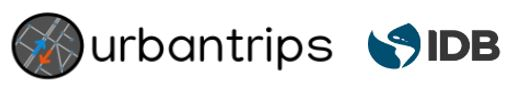

In [4]:
image

In [7]:
viajes.columns

Index(['id_tarjeta', 'id_viaje', 'dia', 'tiempo', 'hora', 'cant_etapas',
       'modo', 'autobus', 'tren', 'metro', 'tranvia', 'brt', 'otros', 'h3_o',
       'h3_d', 'od_validado', 'Corona_o', 'Partido_o', 'Zona_voi_o',
       'Corona_d', 'Partido_d', 'Zona_voi_d', 'distance_osm_drive',
       'distance_osm_walk', 'distance_h3', 'factor_expansion'],
      dtype='object')

In [48]:
import pandas as pd
import geopandas as gpd
import h3
from urbantrips.geo.geo import h3_from_row, h3togeo, create_point_from_h3

# viajes = pd.read_csv('D:\\sanapolsky\\Google Drive\\Python 2.0\\github\\UrbanTrips\\UrbanTrips\\resultados\\data\\amba2_muestra10_viajes.csv')



    # Georeferenciar con h3
# viajes["h3"] = viajes.apply(h3_from_row, axis=1,
#                           args=(5, "latitud", "longitud"))


viajes['h3_5'] = viajes['h3_o'].apply(h3.h3_to_parent, res=6)
# viajes['geometry'] = viajes.h3_5.apply(create_point_from_h3)
viajes.head()

,id_tarjeta,id_viaje,dia,tiempo,hora,cant_etapas,modo,autobus,tren,metro,...,Partido_o,Zona_voi_o,Corona_d,Partido_d,Zona_voi_d,distance_osm_drive,distance_osm_walk,distance_h3,factor_expansion,h3_5
0,0037030029_0,1,2022-11-19,NaN,6,1,autobus,1,0,0,...,La Plata,4.0,RMBA,La Plata,4.0,6.24,NaN,7.38,17.808807,86c2e3db7ffffff
1,0037030029_0,2,2022-11-19,NaN,16,2,Multietapa,2,0,0,...,La Plata,4.0,RMBA,La Plata,4.0,6.24,NaN,7.38,17.808807,86c2e3d87ffffff
2,0037030206_0,1,2022-11-19,NaN,7,1,autobus,1,0,0,...,General San Martín,1.0,Primer cordón,Vicente López,1.0,4.32,NaN,4.61,17.809249,86c2e3157ffffff
3,0037030206_0,2,2022-11-19,NaN,17,1,autobus,1,0,0,...,Vicente López,1.0,Primer cordón,General San Martín,1.0,4.32,NaN,4.61,17.809249,86c2e3157ffffff
4,0037030208_0,1,2022-11-19,NaN,10,1,autobus,1,0,0,...,Comuna 15,1.0,CABA,Comuna 2,1.0,5.86,NaN,5.54,17.810000,86c2e310fffffff


In [49]:


viajes_agg.head()

,hora,h3_5,factor_expansion,geometry,lon_o,lat_o
0,0,86c2e169fffffff,53.440713,POINT (-59.09772 -34.54464),-59.097723,-34.544642
1,0,86c2e2367ffffff,71.251184,POINT (-57.90166 -34.87256),-57.901658,-34.872565
2,0,86c2e2a47ffffff,17.799822,POINT (-58.03158 -34.99196),-58.031581,-34.991959
3,0,86c2e2acfffffff,195.896218,POINT (-57.92446 -34.91257),-57.924463,-34.912572
4,0,86c2e2aefffffff,17.809012,POINT (-57.94727 -34.95253),-57.947268,-34.952534


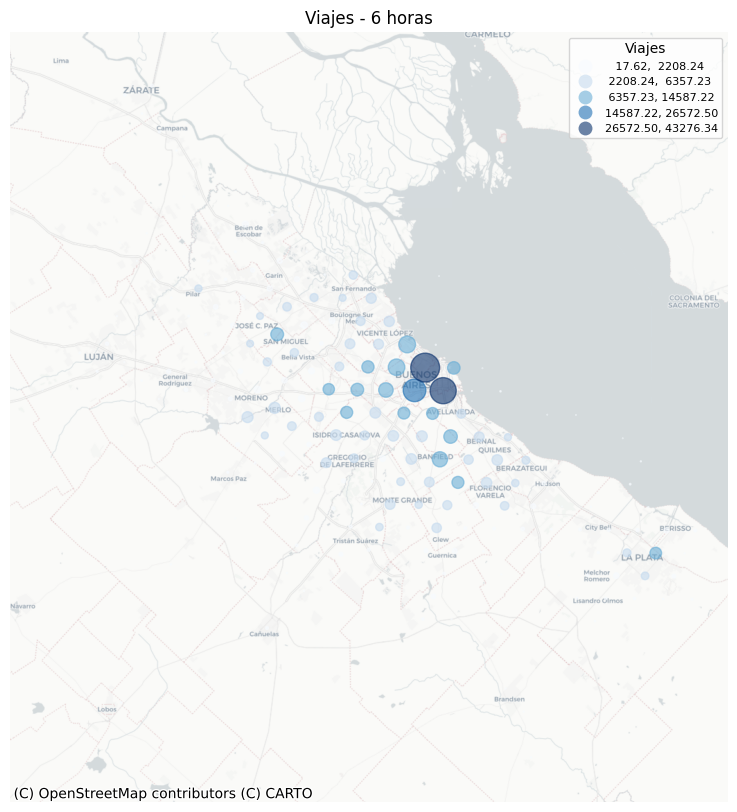

In [55]:
import mapclassify
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
# import seaborn as sns
# from PIL import UnidentifiedImageError
# from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
# from matplotlib.figure import Figure
# import contextily as ctx


viajes_agg = viajes.groupby(['hora', 'h3_5'], as_index=False).factor_expansion.sum()
viajes_agg['geometry'] = viajes_agg.h3_5.apply(h3togeo)

viajes_agg['lon_o'] = (
    viajes_agg["geometry"].str.split(",").apply(
        lambda x: x[1]).str.strip().astype(float)
)
viajes_agg['lat_o'] = (
    viajes_agg["geometry"].str.split(",").apply(
        lambda x: x[0]).str.strip().astype(float)
)


viajes_agg= gpd.GeoDataFrame(
                viajes_agg, geometry=gpd.points_from_xy(viajes_agg['lon_o'], viajes_agg['lat_o']), crs=4326)


viajes_agg = viajes_agg[viajes_agg.hora==10].copy()

title = 'Viajes - 6 horas'

# fig = Figure(figsize=(13.5, 13.5), dpi=100)
# canvas = FigureCanvas(fig)
# ax = fig.add_subplot(111)

fig, ax = plt.subplots(figsize=(10, 10))

viajes_agg.to_crs(3857).plot(ax=ax,
                         alpha=.6,
                         cmap='Blues',
                         markersize=viajes_agg['factor_expansion'] / 100 ,
                         column='factor_expansion',
                         scheme='FisherJenks',
                         k=5,
                         legend=True,
                         legend_kwds={
                             'loc': 'upper right',
                             'title': 'Viajes',
                             'fontsize': 8,
                                'title_fontsize': 10,
                         }
                         )
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,
                attribution=None, attribution_size=10)

ax.axis('off')

ax.set_title(title, fontsize=12);


In [54]:
len(viajes_agg)

4590

In [14]:
def levanto_tabla_sql(tabla_sql, 
                      has_linestring=False,
                      has_wkt=False):

    conn_dash = iniciar_conexion_db(tipo='dash')

    tabla = pd.read_sql_query(
        f"""
        SELECT *
        FROM {tabla_sql}
        """,
        conn_dash,
    )

    conn_dash.close()
    
    if has_linestring:
        tabla = create_linestring(tabla)
        
    if has_wkt:
        tabla["geometry"] = tabla.wkt.apply(wkt.loads)
        tabla = gpd.GeoDataFrame(tabla, 
                                   crs=4326)
        tabla = tabla.drop(['wkt'], axis=1)
    
    return tabla

In [17]:
from shapely import wkt
import pandas as pd
import geopandas as gpd
zonas = levanto_tabla_sql('zonas', has_wkt=True)
zonas.head()

alias amba2_muestra10_
data\db\amba2_muestra10_dash.sqlite


,Zona,tipo_zona,geometry
0,1,Zona_voi,"POLYGON ((-57.95814 -34.36117, -58.33559 -34.7..."
1,2,Zona_voi,"POLYGON ((-58.51493 -34.45506, -58.60833 -34.6..."
2,3,Zona_voi,"POLYGON ((-58.33559 -34.77608, -58.36264 -35.0..."
3,4,Zona_voi,"POLYGON ((-58.10034 -35.04869, -58.11246 -35.0..."
4,5,Zona_voi,"POLYGON ((-58.36264 -35.01616, -58.33559 -34.7..."


In [18]:

zonas #[zonas.Zona=='Partido'] #.plot()

,tipo_zona,Zona,geometry
0,Corona,CABA,"POLYGON ((-58.51617 -34.66237, -58.52016 -34.6..."
1,Corona,Primer cordón,"MULTIPOLYGON (((-58.67329 -34.68338, -58.67404..."
2,Corona,RMBA,"MULTIPOLYGON (((-59.01570 -34.96785, -59.01644..."
3,Corona,Segundo cordón,"MULTIPOLYGON (((-58.85152 -34.70933, -58.85227..."
4,Corona,Tercer cordón,"MULTIPOLYGON (((-58.87929 -34.65630, -58.88307..."
...,...,...,...
69,Zona_voi,5,"POLYGON ((-58.36264 -35.01616, -58.33559 -34.7..."
70,Zona_voi,6,"POLYGON ((-58.83952 -34.28883, -58.85235 -34.3..."
71,Zona_voi,7,"POLYGON ((-58.92105 -34.37789, -58.89713 -34.6..."
72,Zona_voi,8,"POLYGON ((-58.93044 -35.08633, -58.70293 -34.8..."


<Axes: >

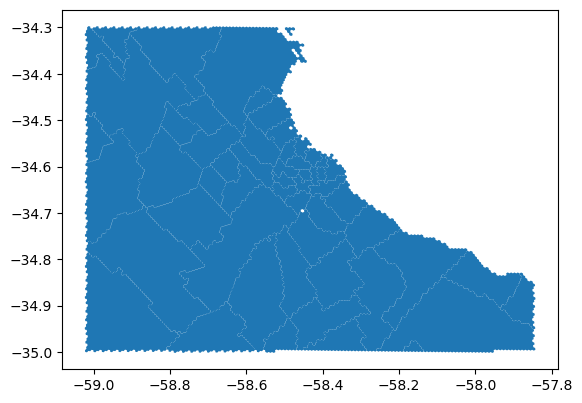

In [24]:
zonas[zonas.tipo_zona=='Partido'].plot()